Importing gempy



In [23]:
# Aux imports
import gempy as gp
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import gstools as gs
import pyvista as pv
import pyvistaqt as pvqt
import PVGeo
import glob
import random
from tqdm import tqdm
from numpy import cross, eye, dot
from scipy.linalg import expm, norm
from sklearn import preprocessing
from pyvista import set_plot_theme
np.random.seed(1515)
pd.set_option('precision', 2)
%matplotlib inline
set_plot_theme('document')

We import a model from an existing folder, representing a subduction
zone with onlap relationships. The theano function is automatically
recombined to allow changes.




In [10]:
#define resolution and mesh size
reso=[50, 50, 50]
mesh_size = reso[0]*reso[1]*reso[2]
extent=[0, 1307, 0, 500, -1257, 50]
print(' mesh size: ' + str(mesh_size))

 mesh size: 125000


In [12]:
geo_data = gp.create_data('foresets', extent=extent, resolution=reso,
                          path_o="2_orientation_data_all.csv",
                          path_i="1_point_data_all.csv")

gp.map_stack_to_surfaces(geo_data, {"Strat_Series1":('topo'),
                                    
                                    "Strat_Series2":('LowerHuakaizuoFm'),
                                    
                                    "Strat_Series3":('BazhuluFm','UpperHuakaizuoFm'),
                                    "Strat_Series4":('Bazhulu2Fm','UpperHuakaizuo2Fm'),
                                    "Basement": ('basement')})

Active grids: ['regular']


,surface,series,order_surfaces,color,id
0,topo,Strat_Series1,1,#015482,1
3,LowerHuakaizuoFm,Strat_Series2,1,#728f02,2
1,BazhuluFm,Strat_Series3,1,#9f0052,3
2,UpperHuakaizuoFm,Strat_Series3,2,#ffbe00,4
4,Bazhulu2Fm,Strat_Series4,1,#443988,5
5,UpperHuakaizuo2Fm,Strat_Series4,2,#ff3f20,6
6,basement,Basement,1,#5DA629,7


In [14]:
geo_data.series.df['BottomRelation'][3]='Onlap'
# geo_data.series.df['BottomRelation'][1]='Fault'
# geo_data.series.df['BottomRelation'][3]='Fault'
# geo_data.set_is_fault(['Fault_Series1'])
# geo_data.set_is_fault(['Fault_Series2'])
geo_data.series

,order_series,BottomRelation,isActive,isFault,isFinite
Strat_Series1,1,Erosion,True,False,False
Strat_Series2,2,Erosion,True,False,False
Strat_Series3,3,Erosion,True,False,False
Strat_Series4,4,Onlap,True,False,False
Basement,5,Erosion,False,False,False


C:\Users\pasha\python\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


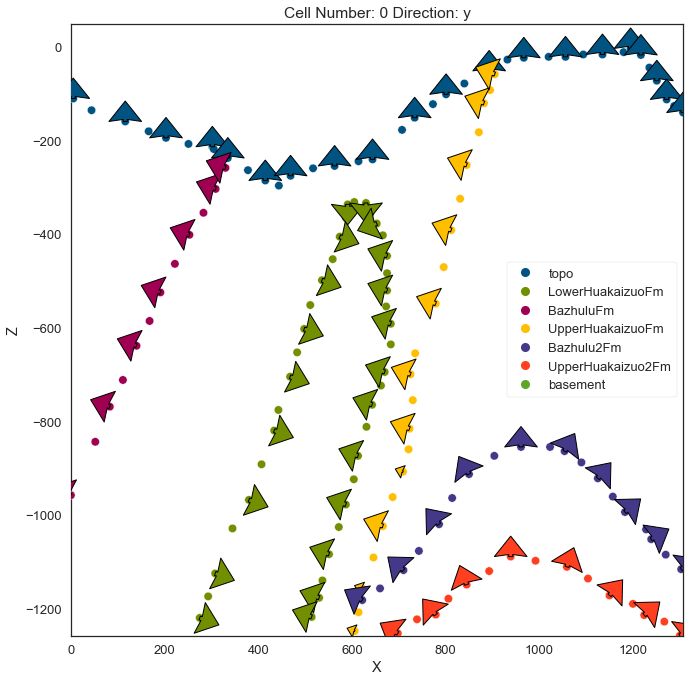

In [15]:
#for resolution of 40x40x40 : 1300m - 19, 2600m - 37
gp.plot_2d(geo_data, cell_number=0, show_data=True, figsize=(10,10)) #58 #29

In [16]:
#set topography surface for good visualization
geo_data.set_topography()

#geo_data.set_topography(source='random', fd=1.5, d_z=np.array([100, 0]), resolution=np.array([400, 400]))
#geo_model._grid.topography.save('test_topo')
#geo_model.set_topography(source='saved', filepath='test_topo.npy')

[-211.4   50. ]
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[   13.07      ,     5.        , -1243.93      ],
       [   13.07      ,     5.        , -1217.79      ],
       [   13.07      ,     5.        , -1191.65      ],
       ...,
       [ 1307.        ,   479.59183673,   -20.77914088],
       [ 1307.        ,   489.79591837,   -30.89354889],
       [ 1307.        ,   500.        ,   -28.73211197]])

In [17]:
interp_data = gp.set_interpolator(geo_data, compile_theano=True,theano_optimizer='fast_compile')

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                           values
range                    1914.81
$C_o$                   87297.57
drift equations  [3, 3, 3, 3, 3]


In [18]:
%%time
sol = gp.compute_model(geo_data, compute_mesh=True, debug=False)

Wall time: 14.6 s


C:\Users\pasha\python\lib\site-packages\gempy\core\solution.py:174: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.geological_map = np.array(


C:\Users\pasha\python\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


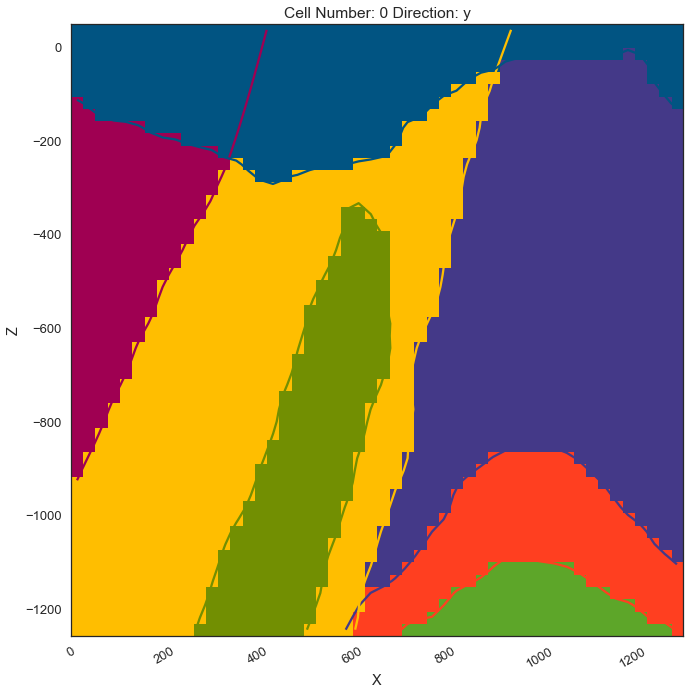

In [19]:
gp.plot_2d(geo_data, direction='y', cell_number=0, show_data=False,  figsize=(10,10))

In [21]:
p3d = gp.plot_3d(geo_data, plotter_type='background', show_lith=True, show_surfaces=True,  show_data=False, image=False,
                 show_topography=True,
                 kwargs_plot_structured_grid={'opacity': .5})

gp.save_model(geo_data)

C:\Users\pasha\python\lib\site-packages\pyvista\plotting\plotting.py:1354: PyvistaDeprecationWarning: 
"stitle" is a depreciated keyword and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyvistaDeprecationWarning)


True

In [20]:
### User-defined functions
def extract_domain(sol, unit):
    '''
    Extract domain coordinates from gempy model by unit name
    arguments:
        sol: Gempy solution object.
        unit: gempy unit by index
    returns:
        dom_x, dom_y, dom_z: coordinates of domain
    '''

    # new version with rounding, definitely necessary
    rounded_lithblock = sol.lith_block.round(0)
    rounded_lithblock = rounded_lithblock.astype(int)

    # mask by array of input surfaces (by id, can be from different series)
    mask = np.isin(rounded_lithblock, unit)

    # get coordinates by mask, mesh_size is defined on in[55]
    #krig_lith = sol.lith_block[mask]
    dom_grid = sol.grid.values[:mesh_size][mask]

    dom_x = dom_grid[:,0]
    dom_y = dom_grid[:,1]
    dom_z = dom_grid[:,2]

    return dom_x, dom_y, dom_z

In [21]:
unit_count=int(np.max(sol.lith_block.round(0)))
series_count=len(sol.scalar_field_matrix)
unit_count, series_count

(7, 4)

### Geostatistics and Kriging
the script below is designed to use two different mineral grading parameters and eventually visualize both in the same grid of the model

In [12]:
#load csv file and introduce it to pandas dataframe
df=pd.read_csv('3_kriging_data_all.csv')
df

,X,Y,Z,grade_value,grade
0,648,0,-251,2.04,Cu grade
1,651,0,-270,2.05,Cu grade
2,664,0,-276,2.04,Cu grade
3,655,0,-264,2.05,Cu grade
4,657,0,-298,2.04,Cu grade
...,...,...,...,...,...
93,780,0,-502,2.04,Cu grade
94,778,0,-523,2.05,Cu grade
95,779,0,-496,2.04,Cu grade
96,789,0,-466,2.04,Cu grade


In [13]:
# This is to extract smaller domains from gempy by 

#ore body generally lies along the fault plane which cuts Upper Huakaizuo Formation (4)

domain_x, domain_y, domain_z = extract_domain(sol, (6))

# grid coordinate preparation
coordinates = np.array([domain_x, domain_y, domain_z])
coordinates = coordinates.swapaxes(0,1)

In [14]:
# define kriging points coordinates and grade values (Cu)
n=len(df.iloc[:,2])
x = df.iloc[:n,0]
y = df.iloc[:n,1]
z = df.iloc[:n,2]
cond_pos = np.array([x,y,z])
cond_val = df.iloc[:n,3]

# define kriging points coordinates and grade values(Lenses)

In [15]:
# Define kriging function (Cu)
#(CondSRF - conditional spatial random fields)
model = gs.Exponential(dim=3, var=np.var(cond_val), len_scale=200)
krige = gs.krige.Ordinary(model, cond_pos, cond_val)

# perform kriging
krige((coordinates[:,0],coordinates[:,1], coordinates[:,2]), mesh_type='unstructured')
# alternatively fior SGS
#cond_srf((coordinates[:,0],coordinates[:,1], coordinates[:,2]), mesh_type='unstructured')

# just convenience rename
field= krige

In [16]:
# convert to pyvista mesh
pc = field.to_pyvista()

In [18]:
# 3D plotting example of Cu krige
spacing = lambda arr: np.unique(np.diff(np.unique(arr)))
voxelsize = spacing(pc.points[:,0]), spacing(pc.points[:,1]), spacing(pc.points[:,2])

pc = pc.cast_to_unstructured_grid()

grade = PVGeo.filters.VoxelizePoints(dx=voxelsize[0][0], dy=voxelsize[1][0], dz=voxelsize[2][0], 
                                        estimate=False).apply(pc)


#a = pc_Cu.plot('3d_field')
#p = pvqt.BackgroundPlotter(pc)


gpv = gp.plot_3d(geo_data, plotter_type='background', show_data=False, show_lith=True, show_surfaces=False,
                kwargs_plot_structured_grid={'opacity': .7})

gpv.p.add_mesh(grade, opacity=1, show_edges=False, lighting=False, cmap="viridis")

(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)00000254322D2E20

In [19]:
# Cu ore density - 8.96 g/cm3
#define grade intervals and check the count of voxels corresponding to the same interval
ore_interval1=[]

for index in tqdm(range(0, len(grade.active_scalars))):
    #for Horizon I:
    if grade.active_scalars[index]>2:
        ore_interval1.append(grade.active_scalars[index])
   
        
#calculate volume of total voxels corresponding to a certain ore grade interval
voxel_volume=((extent[1]-extent[0])/reso[0])*((extent[3]-extent[2])/reso[1])*((extent[5]-extent[4])/reso[2])

ore_avrg_grade=np.mean(ore_interval1)
volume=len(ore_interval1)*(voxel_volume)
print('Horizon1=',volume)
print("Average ore grade=", ore_avrg_grade)

100%|████████████████████████████████| 351624/351624 [04:58<00:00, 1178.19it/s]

Horizon1= 300330673.18799996
Average ore grade= 2.0433055112522513


### Extract kriged data

In [24]:
%%time
main_array=pc.points.tolist()
added_array=grade.active_scalars.tolist()
n=len(main_array)

for index in range(0,n,1):
    main_array[index].append(added_array[index])
grade=pd.DataFrame(main_array, columns=['X','Y','Z','grade'])
grade

Wall time: 225 ms


,X,Y,Z,grade
0,13.07,5.0,-1243.93,2.04
1,13.07,5.0,-1217.79,2.04
2,13.07,5.0,-1191.65,2.04
3,13.07,5.0,-1165.51,2.04
4,13.07,5.0,-1139.37,2.04
...,...,...,...,...
43944,901.83,475.0,-119.91,2.04
43945,901.83,485.0,-146.05,2.04
43946,901.83,485.0,-119.91,2.04
43947,901.83,495.0,-146.05,2.04


In [25]:
#drill boreholess!!
def krige_boreholes(b_count):
    borehole_count=range(0,b_count,1)
    rand_ind=random.sample(range(0,len(grade)),b_count)
    dict_all={}
    boreholes_dict={}

    for index in tqdm(borehole_count):
        list_temp=[]
        for row in grade.itertuples():
            if (grade.iloc[rand_ind[index]].X==row.X and grade.iloc[rand_ind[index]].Y==row.Y):
                list_temp.append([row.X,row.Y,row.Z,row.grade])
                
        dict_all.update({index+1:list_temp})

    for index in range(0,b_count,1): 
        data_temp = pd.DataFrame(dict_all[index+1])
        data_temp.columns=['X','Y','Z','grade']
        data_temp.loc[:, 'borehole']=index+1
        boreholes_dict.update({index+1:data_temp})
    return boreholes_dict
        
boreholes=krige_boreholes(100)

100%|████████████████████████████████████████| 100/100 [07:59<00:00,  4.79s/it]


In [26]:
drill_all = pd.concat(boreholes.values(), ignore_index=True)
drill_all

,X,Y,Z,grade,borehole
0,849.55,15.0,-224.47,2.04,1
1,849.55,15.0,-198.33,2.04,1
2,849.55,15.0,-172.19,2.04,1
3,849.55,15.0,-146.05,2.04,1
4,849.55,15.0,-119.91,2.04,1
...,...,...,...,...,...
2882,692.71,335.0,-302.89,2.04,100
2883,692.71,335.0,-276.75,2.04,100
2884,692.71,335.0,-250.61,2.04,100
2885,692.71,335.0,-224.47,2.04,100


In [28]:
list_tempo=[]
for index in range(0,len(drill_all),10):
    list_tempo.append(drill_all.iloc[index])
br=pd.DataFrame(list_tempo)

br.to_csv('3_kriging_100.csv')
br

,X,Y,Z,grade,borehole
0,849.55,15.0,-224.47,2.04,1.0
10,274.47,495.0,-1139.37,2.04,2.0
20,274.47,495.0,-877.97,2.04,2.0
30,274.47,495.0,-616.57,2.04,2.0
40,248.33,475.0,-1243.93,2.04,3.0
...,...,...,...,...,...
2840,379.03,205.0,-694.99,2.04,99.0
2850,379.03,205.0,-433.59,2.04,99.0
2860,692.71,335.0,-877.97,2.04,100.0
2870,692.71,335.0,-616.57,2.04,100.0


In [29]:
vertices = drill_all[['X','Y','Z']].values
kriged=pv.PolyData(vertices)
kriged['grade'] = drill_all['grade'].values
kriged

PolyData (0x17b82ef40a0)
  N Cells:	2887
  N Points:	2887
  X Bounds:	1.307e+01, 8.496e+02
  Y Bounds:	5.000e+00, 4.950e+02
  Z Bounds:	-1.244e+03, -9.377e+01
  N Arrays:	1

In [30]:
p = pvqt.BackgroundPlotter()
gpv = gp.plot_3d(geo_data, plotter_type='background', show_data=False, show_lith=True, show_surfaces=True,
                kwargs_plot_structured_grid={'opacity': .3})

#creating the grade mesh calculated with kriging (colormap) 
gpv.p.add_mesh(kriged, scalars='grade', opacity=1, cmap='viridis', point_size=5)

C:\Users\pasha\python\lib\site-packages\pyvista\plotting\plotting.py:1354: PyvistaDeprecationWarning: 
"stitle" is a depreciated keyword and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyvistaDeprecationWarning)


(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)0000017BCD1DEFA0

### Extract orientation data from the solution

In [24]:
#define the function to calculate gradient (dict_spec)

def get_gradient(sol, res, dim):
    '''
    Calculate gradient from model solution
    '''
    # scalar field as meshgrid
    dict_all={}
    dict_spec={}
    for index in range(0,series_count,1):
        scalar_mgrid = sol.scalar_field_matrix[index].reshape(res)

        # calculate gradient
        gx, gy, gz = np.gradient(scalar_mgrid)

       
        vectors = np.array([gx.reshape(int(res[0] ** dim)), gy.reshape(int(res[0] ** dim)), gz.reshape(int(res[0] ** dim))])
        vectors = np.swapaxes(vectors, 0, 1)
        vectors = preprocessing.normalize(vectors, norm='l2')
        dict_all.update({index:vectors})
         
    
    for index in range(0,series_count,1):
            data_temp = pd.DataFrame(dict_all[index])
            dict_spec.update({'series_{}'.format(index):data_temp})
    return dict_spec

dict_spec=get_gradient(sol, res=[50,50,50], dim=3)

#define cell locations and correspoding domain name
x=sol.grid.regular_grid.values[:, 0]
y=sol.grid.regular_grid.values[:, 1]
z=sol.grid.regular_grid.values[:, 2]
formation=sol.lith_block

#add cell locations and domain names to the gradient dataframe
for key,value in dict_spec.items():
    #load coordinate and formation array to the whole series dataframes
    value["X"]=x
    value['Y']=y
    value['Z']=z
    value['formation']=formation
    #value = value.reset_index()
    #define column names
    value.columns=['G_x','G_y','G_z','X','Y','Z','formation'] 
    
dict_spec['series_0']=dict_spec['series_0'][dict_spec['series_0'].formation==1]
dict_spec['series_1']=dict_spec['series_1'][dict_spec['series_1'].formation==2]
dict_spec['series_2'] = dict_spec['series_2'].loc[(dict_spec['series_2'].formation > 2) & (dict_spec['series_2'].formation < 5)]
dict_spec['series_3']=dict_spec['series_3'].drop(dict_spec['series_3'][(dict_spec['series_3'].formation<=4)].index)

orientations = pd.concat([dict_spec['series_0'],dict_spec['series_1'],dict_spec['series_2'], dict_spec['series_3']], ignore_index=True)
orientations

,G_x,G_y,G_z,X,Y,Z,formation
0,0.34,2.00e-02,0.94,13.07,5.0,-93.77,1.0
1,0.24,8.87e-03,0.97,13.07,5.0,-67.63,1.0
2,0.20,5.33e-03,0.98,13.07,5.0,-41.49,1.0
3,0.18,3.58e-03,0.98,13.07,5.0,-15.35,1.0
4,0.17,2.53e-03,0.99,13.07,5.0,10.79,1.0
...,...,...,...,...,...,...,...
124954,0.25,2.84e-02,0.97,1293.93,495.0,-146.05,5.0
124955,0.24,2.61e-02,0.97,1293.93,495.0,-119.91,5.0
124956,0.23,2.39e-02,0.97,1293.93,495.0,-93.77,5.0
124957,0.22,2.17e-02,0.98,1293.93,495.0,-67.63,5.0


In [25]:
#extract mesh grid for ideal case 3D model
unit=range(0,unit_count+1)
for index in unit:
    domain_x, domain_y, domain_z = extract_domain(sol, (unit[index+1]))
    coordinates = np.array([domain_x, domain_y, domain_z])
    coordinates = coordinates.swapaxes(0,1)
    data=pd.DataFrame(coordinates, columns=['X','Y','Z'])
    data.loc[:, 'formation'] =float(unit[index+1])
    data.to_csv(r'data_extracted/ideal/unit_{}.csv'.format(unit[index+1]), mode="w", index=False)

IndexError: range object index out of range

In [26]:
# join all the files into one dataframe
path =r'data_extracted/ideal/'

filenames = glob.glob(path + "/*.csv")

dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))

# Concatenate all domain data into one DataFrame for ideal case mesh grid
ideal = pd.concat(dfs, ignore_index=True)
#df.drop(df.columns[[0]], axis=1, inplace=True)

#compare orientation data to ideal case data. Pick only the same cells in order to avoid basement data interference because
#basement data is not needed for model construction
df_same = orientations.merge(ideal, left_on=('X','Y','Z','formation'), right_on=('X','Y','Z','formation'), how='inner')
df_same = df_same[df_same.formation != unit_count]
df_same

,G_x,G_y,G_z,X,Y,Z,formation
0,0.34,2.00e-02,0.94,13.07,5.0,-93.77,1.0
1,0.24,8.87e-03,0.97,13.07,5.0,-67.63,1.0
2,0.20,5.33e-03,0.98,13.07,5.0,-41.49,1.0
3,0.16,1.81e-03,0.99,13.07,5.0,36.93,1.0
4,0.34,2.78e-02,0.94,13.07,15.0,-93.77,1.0
...,...,...,...,...,...,...,...
85511,0.26,3.08e-02,0.97,1293.93,495.0,-172.19,5.0
85512,0.25,2.84e-02,0.97,1293.93,495.0,-146.05,5.0
85513,0.23,2.39e-02,0.97,1293.93,495.0,-93.77,5.0
85514,0.22,2.17e-02,0.98,1293.93,495.0,-67.63,5.0


In [27]:
#drill boreholess!!
def d_boreholes(b_count):
    borehole_count=range(0,b_count,1)
    rand_ind=random.sample(range(0,len(df_same)),b_count)
    dict_all={}
    boreholes_dict={}

    for index in tqdm(borehole_count):
        list_temp=[]
        for row in df_same.itertuples():
            if (df_same.iloc[rand_ind[index]].X==row.X and df_same.iloc[rand_ind[index]].Y==row.Y):
                list_temp.append([row.X,row.Y,row.Z,row.G_x, row.G_y, row.G_z, row.formation])
                
        dict_all.update({index+1:list_temp})

    for index in range(0,b_count,1): 
        data_temp = pd.DataFrame(dict_all[index+1])
        data_temp.columns=['X','Y','Z','G_x','G_y','G_z','formation']
        data_temp.loc[:, 'borehole']=index+1
        boreholes_dict.update({index+1:data_temp})
    return boreholes_dict

#define desired number of boreholes
boreholes_dict=d_boreholes(100)

#join all borehole data into one dataframe
df = pd.concat(boreholes_dict.values(), ignore_index=True)
# boreholes_dict.to_csv('test100')

#load joined csv dataset
bore_count = df['borehole'].nunique()

#create mesh grid and define vertices, convert it to a pyvista poly data
vertices = df[['X', 'Y', 'Z']].values
grid=pv.PolyData(vertices)
grid['formation'] = df['formation'].values

  2%|▊                                         | 2/100 [00:16<13:09,  8.05s/it]


KeyboardInterrupt: 

In [47]:
unit=('topo','LowerHuakaizuoFm', 'BazhuluFm','UpperHuakaizuoFm','Bazhulu2Fm',
      'UpperHuakaizuo2Fm')
for index in range(1,unit_count):
    df['formation'] = df.loc[:,'formation'].replace(index,unit[index-1])
# boreholes[boreholes['formation']=='quartzite2'] - just for checking the dataset
df

,X,Y,Z,G_x,G_y,G_z,formation,borehole
0,65.35,175.0,-146.05,0.29,4.09e-02,0.96,topo,1
1,65.35,175.0,-93.77,0.28,3.68e-02,0.96,topo,1
2,65.35,175.0,-67.63,0.26,3.37e-02,0.96,topo,1
3,65.35,175.0,-41.49,0.25,2.99e-02,0.97,topo,1
4,65.35,175.0,36.93,0.21,1.63e-02,0.98,topo,1
...,...,...,...,...,...,...,...,...
3912,431.31,145.0,-433.59,-0.92,-1.96e-03,0.40,UpperHuakaizuoFm,99
3913,431.31,145.0,-407.45,-0.92,-4.04e-03,0.40,UpperHuakaizuoFm,99
3914,431.31,145.0,-329.03,-0.93,-9.20e-03,0.37,UpperHuakaizuoFm,99
3915,431.31,145.0,-302.89,-0.94,-1.01e-02,0.35,UpperHuakaizuoFm,99


In [100]:
p = pvqt.BackgroundPlotter()
gpv = gp.plot_3d(geo_data, plotter_type='background', show_data=False, show_lith=True, show_surfaces=True,
                kwargs_plot_structured_grid={'opacity': .3})

#creating the grade mesh calculated with kriging (colormap) 
gpv.p.add_mesh(grid, scalars='formation', opacity=1, cmap='viridis', point_size=15)

C:\Users\pasha\python\lib\site-packages\pyvista\plotting\plotting.py:1354: PyvistaDeprecationWarning: 
"stitle" is a depreciated keyword and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyvistaDeprecationWarning)


(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)000001C5AC328A00

### Extract data from boreholes to generate point data for the regenerated model

In [48]:
#picking lowermost boundary for each formation through the borehole data 

dict_all=[]
list_temp=[]

for br in range(1,bore_count+1,1):
    for fr in range(1,form_count+1,1):
          list_temp.append(df[(df['borehole']==br) & (df['formation']==unit[fr-2])])
list_temp2=[]
for i in list_temp:
    if(not i.empty):
        list_temp2.append(i.iloc[0])
df_b=pd.DataFrame(list_temp2, index=range(0,len(list_temp2),1))
del df_b['borehole']
#df_b = df_b[df_b.formation != 'LowerHuakaizuoFm']
df_b

,X,Y,Z,G_x,G_y,G_z,formation
0,65.35,175.0,-146.05,0.29,4.09e-02,0.96,topo
1,65.35,175.0,-799.55,-0.91,1.07e-02,0.40,BazhuluFm
2,65.35,175.0,-1243.93,-0.96,2.30e-02,0.29,UpperHuakaizuoFm
3,196.05,415.0,-172.19,0.21,1.65e-02,0.98,topo
4,196.05,415.0,-538.15,-0.92,1.00e-02,0.40,BazhuluFm
...,...,...,...,...,...,...,...
310,431.31,145.0,-904.11,-0.91,4.13e-03,0.41,UpperHuakaizuoFm
311,849.55,75.0,-1113.23,-0.61,-7.27e-05,0.79,UpperHuakaizuo2Fm
312,849.55,75.0,-67.63,-0.51,2.61e-02,0.86,topo
313,849.55,75.0,-224.47,-0.96,6.92e-03,0.30,UpperHuakaizuoFm


In [49]:
#picking lowermost boundary for each formation through the borehole data 

dict_all1=[]
list_temp1=[]

for br in range(1,bore_count+1,1):
    for fr in range(1,form_count+1,1):
          list_temp1.append(df[(df['borehole']==br) & (df['formation']==unit[fr-2])])
list_temp2=[]
for df in list_temp1:
    if(not df.empty):
        list_temp2.append(df.iloc[-1])
df_f=pd.DataFrame(list_temp2, index=range(0,len(list_temp2),1))
del df_f['borehole']
df_f=df_f[df_f['formation']=='LowerHuakaizuoFm']
df_f

,X,Y,Z,G_x,G_y,G_z,formation
13,588.15,105.0,-485.87,0.65,-0.44,-0.62,LowerHuakaizuoFm
16,352.89,65.0,-1034.81,0.89,-0.08,-0.45,LowerHuakaizuoFm
59,431.31,55.0,-851.83,0.94,-0.06,-0.33,LowerHuakaizuoFm
100,431.31,95.0,-877.97,0.93,-0.12,-0.34,LowerHuakaizuoFm
103,535.87,115.0,-590.43,0.90,-0.24,-0.37,LowerHuakaizuoFm
113,614.29,125.0,-512.01,-0.50,-0.65,-0.57,LowerHuakaizuoFm
135,352.89,195.0,-1243.93,0.78,-0.59,-0.21,LowerHuakaizuoFm
162,431.31,85.0,-877.97,0.93,-0.11,-0.34,LowerHuakaizuoFm
165,588.15,155.0,-590.43,0.03,-0.84,-0.55,LowerHuakaizuoFm
260,300.61,55.0,-1165.51,0.95,-0.05,-0.32,LowerHuakaizuoFm


In [50]:
joined=pd.concat([df_b,df_f])
#joined[joined['formation']=='pipe']

t = pd.CategoricalDtype(categories=['topo','LowerHuakaizuoFm', 'BazhuluFm','UpperHuakaizuoFm','Bazhulu2Fm',
                                    'UpperHuakaizuo2Fm'], ordered=True)
joined['formation']=pd.Series(joined.formation, dtype=t)
joined.sort_values(by=['formation'],inplace=True)
joined

,X,Y,Z,G_x,G_y,G_z,formation
0,65.35,175.0,-146.05,0.29,4.09e-02,0.96,topo
183,692.71,85.0,-172.19,-0.71,-1.77e-04,0.71,topo
186,562.01,235.0,-224.47,-0.29,-4.15e-02,0.96,topo
188,509.73,455.0,-224.47,-0.16,-4.13e-02,0.99,topo
78,823.41,335.0,-93.77,-0.43,3.04e-02,0.90,topo
...,...,...,...,...,...,...,...
171,692.71,195.0,-1243.93,-0.74,6.71e-02,0.67,UpperHuakaizuo2Fm
44,1084.81,305.0,-1165.51,0.36,1.63e-01,0.92,UpperHuakaizuo2Fm
167,823.41,155.0,-1165.51,-0.61,5.09e-02,0.79,UpperHuakaizuo2Fm
255,692.71,295.0,-1243.93,-0.73,8.49e-02,0.68,UpperHuakaizuo2Fm


In [51]:
joined.to_csv(r'data_all_test100.csv', index = False)